In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np

In [3]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2024-01-03 09:50:56.026892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 09:50:56.034971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 09:50:56.198772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [100]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '../logging/proposals/'
run_name = 'pretty-aardvark-45'

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [101]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

# restored_state = state

In [102]:
# ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
# restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=7000)

# if state is restored_state:
#     raise FileNotFoundError(f"Did not load checkpoint correctly")

In [103]:
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# raw_restored = orbax_checkpointer.restore('../logging/proposals/misunderstood-armadillo-34/ckpts/step_loss_7000/default/')

In [104]:
import orbax

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = orbax.checkpoint.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)
ckpt_mgr = orbax.checkpoint.CheckpointManager(f"{ckpt_dir}/ckpts/", orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()), mgr_options)

restore_args = flax.training.orbax_utils.restore_args_from_target(state, mesh=None)
restored_state = ckpt_mgr.restore(ckpt_mgr.latest_step(), items=state, restore_kwargs={'restore_args': restore_args})

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [105]:
from utils.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")

ds = make_dataloader(files, batch_size=32, seed=42, split="val", shuffle=True)
batches = iter(ds)

In [106]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [107]:
from dm_pix import center_crop

In [108]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1, keepdims=True)
    norm_vec2 = np.linalg.norm(vec2, axis=-1, keepdims=True)

    vec1 /= norm_vec1
    vec2 /= norm_vec2
        
    return np.dot(vec1, vec2)

## Zero-shot classification

In [175]:
# import jax.numpy as np

# images, captions = next(batches)
# images = np.array(images)
# captions = captions.numpy().tolist()
# captions = [c.decode('utf-8') for c in captions]

In [176]:
# images_in = center_crop(images, 224, 224)
# inputs_images = processor(text=captions, images=(images_in * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [177]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from matplotlib.patches import Rectangle

# hubble_observation_categories = [
#     "star forming galaxies", "lyman alpha", "dust", 
#     "crowded stellar field", "core-collapse supernova", "cosmology", 
#     "gravitational lensing", "supernovae", "diffuse galaxies", 
#     "globular clusters", "stellar populations", "interstellar medium", 
#     "black holes", "dark matter", "galaxy clusters", 
#     "galaxy evolution", "galaxy formation", "quasars", 
#     "circumstellar disks", "exoplanets", "Kuiper Belt objects", 
#     "solar system objects", "cosmic web structure", "distant galaxies", 
#     "galaxy mergers", "galaxy interactions", "star formation", 
#     "stellar winds", "brown dwarfs", "neutron stars", 
#     "white dwarfs", "nebulae", "star clusters", 
#     "galaxy archeology", "galactic structure", "active galactic nuclei", 
#     "gamma-ray bursts", "stellar nurseries", "intergalactic medium", 
#     "dark energy", "dwarf galaxies", "barred spiral galaxies", 
#     "irregular galaxies", "starburst galaxies", "low surface brightness galaxies", 
#     "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", 
#     "cosmic dust", "interstellar chemistry", "star formation histories", 
#     "initial mass function", "stellar proper motions", "binary star systems", 
#     "open clusters", "pre-main sequence stars", "protostars", 
#     "protoplanetary disks", "jets and outflows", "interstellar shocks", 
#     "HII regions", "planetary nebulae", "supernova remnants", 
#     "red giants", "Cepheid variables", 
#     "RR Lyrae variables", "stellar abundances", "stellar dynamics", 
#     "compact stellar remnants", "Einstein rings","trans-Neptunian objects",
#     "cosmic microwave background", 
#     "reionization epoch", "first stars", "first galaxies", 
#     "high-redshift quasars", "primordial black holes", "resolved binaries", 
#     "binary stars"
# ]

# hubble_observation_categories_inputs = tokenizer(hubble_observation_categories, padding="max_length", truncation=True, max_length=77, return_tensors="np")

# def display_content(image, paragraph, classes):
#     # Create a figure and define the grid specification
#     fig = plt.figure(figsize=(7, 5))
#     gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

#     # Display the image on the left subplot (spanning all rows)
#     ax0 = plt.subplot(gs[:, 0])
#     ax0.imshow(image)
#     ax0.axis('off')  # Turn off axis numbers and ticks

#     # Display the list of classes on the right subplot (spanning all rows)
#     ax2 = plt.subplot(gs[:, 1])
#     # Add ranking numbers and the title "Top Classes"
#     ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
#     class_text = "Top Classes by Cos. Sim.:\n" + "\n".join(ranked_classes)
#     ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
#     ax2.axis('off')  # Turn off axis numbers and ticks

#     plt.tight_layout()
#     plt.show()

In [174]:
# import matplotlib.pyplot as plt

# # Assuming these functions and variables are already defined:
# # model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

# indices = [1,3,4,7,9]  # Replace with your list of indices
# num_rows = len(indices)

# # Adjust the figsize and width_ratios as needed
# fig = plt.figure(figsize=(20, 18))  # Increased width for better layout
# gs = gridspec.GridSpec(nrows=num_rows, ncols=4, width_ratios=[1, 1, 1, 2])

# for row, idx in enumerate(indices):
#     # Compute features, similarities, etc. as before

#     image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
#     text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
#     cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat[0]))[::-1]][:5]
#     ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
#     cats_text = "\n".join(ranked_cats)

#     # Add image to the first column
#     ax_img = fig.add_subplot(gs[row, 0])
#     ax_img.imshow(images[idx])
#     ax_img.axis('off')

#     # Add science cases to the second column
#     ax_science = fig.add_subplot(gs[row, 1])
#     ax_science.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=16)
#     ax_science.axis('off')

#     image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=state.params);
#     text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
#     cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat[0]))[::-1]][:5]
#     ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
#     cats_text = "\n".join(ranked_cats)

#     # Add science cases to the second column
#     ax_science2 = fig.add_subplot(gs[row, 2])
#     ax_science2.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=16)
#     ax_science2.axis('off')

#     # Add true abstract to the fourth column
#     ax_abstract = fig.add_subplot(gs[row, 3])
#     # Adjust the x-position and width of the text for better wrapping
#     ax_abstract.text(0.05, 0.5, captions[idx], va='center', ha='left',fontsize=9, wrap=True, usetex=False)
#     ax_abstract.axis('off')

#     if row == 0:
#         ax_img.set_title(r"\textbf{Image}")
#         ax_science.set_title(r"\textbf{Top classes (fine-tuned)}")
#         ax_science2.set_title(r"\textbf{Top classes (base)}")
#         ax_abstract.set_title(r"\textbf{Abstract}")

# # Add a general title for the whole figure (optional)
# fig.suptitle(r'\textbf{Image-to-Text Retrieval}', fontsize=20, y=1.02)

# # Adjust layout and display the plot
# plt.tight_layout()
# # plt.savefig("../paper/plots/itt.pdf", bbox_inches='tight', dpi=500)

## Text-to-image retrieval

In [113]:
from tqdm import tqdm

In [114]:
from utils.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False)
batches = iter(ds)

In [115]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

100%|██████████████████████████████████████| 100/100 [03:20<00:00,  2.01s/it]


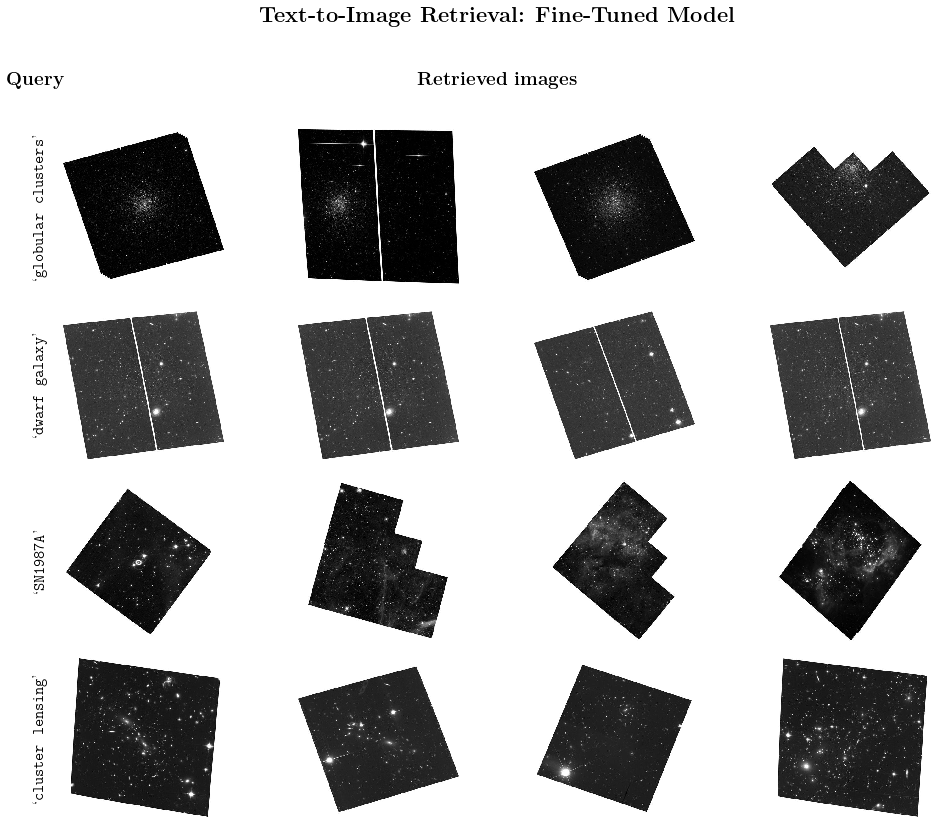

In [191]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 16 * len(queries) / 5.))

# Add a main title
plt.suptitle(r"\textbf{Text-to-Image Retrieval: Fine-Tuned Model}", fontsize=22, fontweight='bold')

axes_list = []
sorted_idxs_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add the query name to the left of the first column
        if col == 0:
            plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')

# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.1, 0.9, r"\textbf{Query}", fontsize=19, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Retrieved images}", fontsize=19, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.1, hspace=0.1)
plt.savefig("../paper/plots/tti.pdf", dpi=500)

In [186]:
[captions_stack[idx] for idx in sorted_idxs_list[2]][:1]

['Category: HOT STARS.  Supernovae explode to create the chemical history of the Universe and energize the interstellar gas. They now occupy center stage for the extragalactic distance scale and cosmology. The SINS program has shown how HST can make unique contributions to understanding supernovae. HST is better than ever for this work: STIS is ideal for spatially-resolved observations of SN 1987A, where a rapidly developing encounter between the fast-moving debris and the stationary inner ring is underway. Observations of UV emission inside the inner ring of SN 1987A reveal the location and velocity of the reverse shock that also produces X-ray and radio emission. We also plan intensive study of illuminating objects beyond SN 1987A: a Target-of-Opportunity observation of a bright, new supernova that is certain to be discovered during Cycle 9, and the late-time observations of SN 1999by {SN Ia} and SN 1998bw, {SN Ic? and probably Gamma-ray burst}. We request a 24-hour turn-around becau

## Base model

In [126]:
batches = iter(ds)

In [127]:
import jax

image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_base_stack += captions

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

100%|██████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


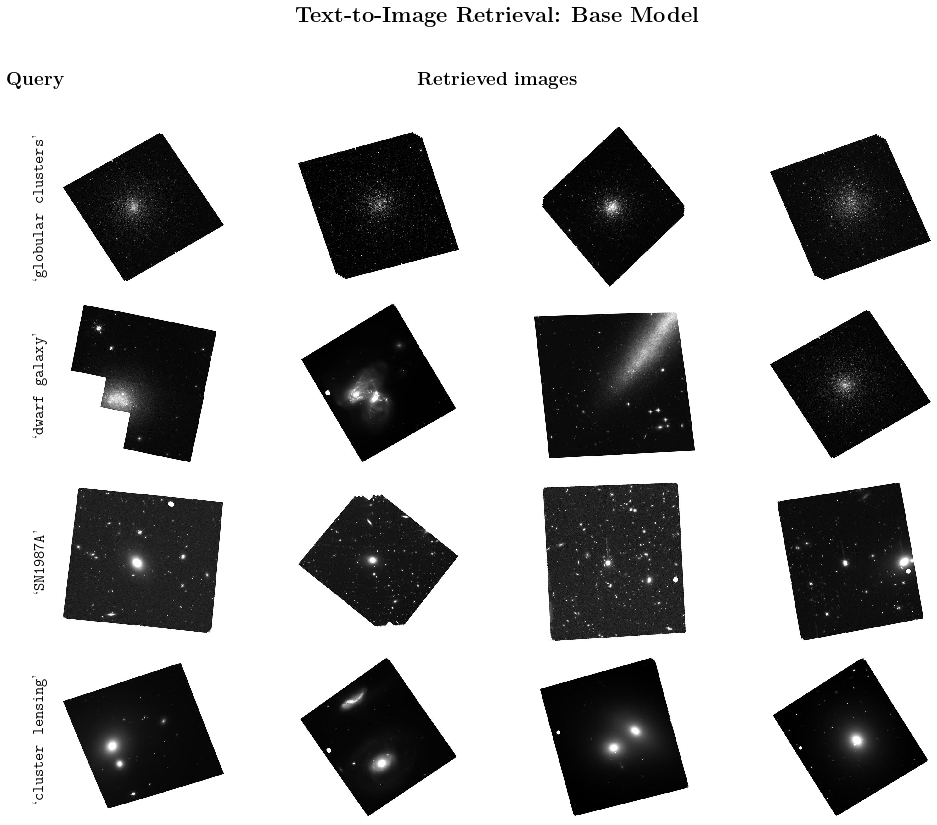

In [193]:
# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 16 * len(queries) / 5.))

# Add a main title
plt.suptitle(r"\textbf{Text-to-Image Retrieval: Base Model}", fontsize=22, fontweight='bold')

axes_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_base_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add the query name to the left of the first column
        if col == 0:
            plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')

# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.1, 0.9, r"\textbf{Query}", fontsize=19, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Retrieved images}", fontsize=19, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.1, hspace=0.1)
plt.savefig("../paper/plots/tti_base.pdf", dpi=500)

## Zero-shot classification

In [194]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

hubble_observation_categories = [
    "star forming galaxies", "lyman alpha", "dust", 
    "crowded stellar field", "core-collapse supernova", "cosmology", 
    "gravitational lensing", "supernovae", "diffuse galaxies", 
    "globular clusters", "stellar populations", "interstellar medium", 
    "black holes", "dark matter", "galaxy clusters", 
    "galaxy evolution", "galaxy formation", "quasars", 
    "circumstellar disks", "exoplanets", "Kuiper Belt objects", 
    "solar system objects", "cosmic web structure", "distant galaxies", 
    "galaxy mergers", "galaxy interactions", "star formation", 
    "stellar winds", "brown dwarfs", 
    "white dwarfs", "nebulae", "star clusters", 
    "galaxy archeology", "galactic structure", "active galactic nuclei", 
    "gamma-ray bursts", "stellar nurseries", "intergalactic medium", 
    "dark energy", "dwarf galaxies", "barred spiral galaxies", 
    "irregular galaxies", "starburst galaxies", "low surface brightness galaxies", 
    "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", 
    "cosmic dust", "interstellar chemistry", "star formation histories", 
    "initial mass function", "stellar proper motions", "binary star systems", 
    "open clusters", "pre-main sequence stars", "protostars", 
    "protoplanetary disks", "jets and outflows", "interstellar shocks", 
    "planetary nebulae", "supernova remnants", 
    "red giants", "Cepheid variables", 
    "RR Lyrae variables", "stellar abundances", "stellar dynamics", 
    "compact stellar remnants", "Einstein rings","trans-Neptunian objects",
    "cosmic microwave background", 
    "reionization epoch", "first stars", "first galaxies", 
    "high-redshift quasars", "primordial black holes", "resolved binaries", 
    "binary stars"
]

hubble_observation_categories_inputs = tokenizer(hubble_observation_categories, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes by Cos. Sim.:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming these functions and variables are already defined:
# model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

indices = [sorted_idxs_list[i][0] for i in range(4)]  # Replace with your list of indices
num_rows = len(indices)

# Adjust the figsize and width_ratios as needed
fig = plt.figure(figsize=(20, 18))  # Increased width for better layout
gs = gridspec.GridSpec(nrows=num_rows, ncols=3, width_ratios=[1, 1, 1])


for row, idx in enumerate(indices):
    # Compute features, similarities, etc. as before

    image_feat = np.vstack(image_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:3]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add image to the first column
    ax_img = fig.add_subplot(gs[row, 0])
    ax_img.imshow(get_image_from_stack(images_stack, idx))
    ax_img.axis('off')

    # Add science cases to the second column
    ax_science = fig.add_subplot(gs[row, 1])
    ax_science.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=23)
    ax_science.axis('off')

    image_feat = np.vstack(image_base_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:3]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add science cases to the second column
    ax_science2 = fig.add_subplot(gs[row, 2])
    ax_science2.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=23)
    ax_science2.axis('off')

    # # Add true abstract to the fourth column
    # ax_abstract = fig.add_subplot(gs[row, 3])
    # # Adjust the x-position and width of the text for better wrapping
    # # ax_abstract.text(0.05, 0.5, captions[idx], va='center', ha='left',fontsize=9, wrap=True, usetex=False)
    # ax_abstract.axis('off')

    if row == 0:
        ax_img.set_title(r"\textbf{Image}")
        ax_science.set_title(r"\textbf{Top classes (fine-tuned)}")
        ax_science2.set_title(r"\textbf{Top classes (base)}")
        # ax_abstract.set_title(r"\textbf{Abstract}")

# Add a general title for the whole figure (optional)
fig.suptitle(r'\textbf{Image-to-Text Retrieval}', fontsize=20, y=1.02)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("../paper/plots/itt.pdf", bbox_inches='tight', dpi=500)

## Viz embeddings

In [195]:
# import jax.numpy as np
# from sklearn.manifold import TSNE
# X = np.vstack(image_feat_stack)[:6000]
# X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

In [196]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_embedded = pca.fit_transform(np.vstack(image_feat_stack)[:])

In [197]:
# pca.explained_variance_ratio_

In [198]:
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)